## Huggett Model

- Author: Joao B. Duarte
- Last Update: 9/11/2020

In [1]:
# Import Libraries
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import interp1d
from quantecon.markov import DiscreteDP
import matplotlib.pyplot as plt
from time import time
from matplotlib import rc
plt.style.use({'figure.facecolor':'white'})
rc('text', usetex=True)
%config InlineBackend.figure_format = 'retina'

Why market incompleteness?

- Complete markets assumption generates predictions in a broad set of models that are greatly inconsistent with the data
Carroll and Young (2009).

- Incomplete markets + idiosyncratic shocks: a way of producing robust and real world-like predictions for inequality.

### The incomplete-markets setting: the consumer

- Preferences: $E\sum_{t=0}^\infty β^t u(c_t)$.

- Consumption possibility set: budget $c_t + a_{t+1} = ε_t + (1+r_t) a_t$, borrowing constraint $a_{t+1} ≥ \phi$, and $c_t ≥ 0$.

- Asset markets: no insurance market but a riskless bond, priced at $r_t$.

- Shock process: labor income is $ε∈{ε_h,ε_l}$, with first-order Markov transitions: $\Pi = \begin{pmatrix} π_h & 1-π_h \\
 π_l & 1- π_l
\end{pmatrix}
$



####  Aggregate environment in which the consumer lives

- Other people: initially, at $t = 0$, a continuum of consumers with different asset holdings and different labor
income statuses. Joint distribution: the measure $Γ_0(a, ε)$.

- Aggregate shocks: none. Labor income shocks uncorrelated across agents. Law of large number holds. If $φ_t$ is the
fraction with $ε=ε_h$ at time $t$, we have $φ_{t+1}=φ_t π_h+(1−φ_t)π_l$.

- Market clearing for the asset: $\int_{\phi} a_{i,t+1} di = 0$ for all $t$, with a initial condition
$\int_{\phi} a_{i,0} di = 0$; $i$ denotes agent $i$.

- Aggregate resource constraint: an endowment economy, and thus $\int c_{i,t} di = \intε_{i,t}di$ for all $t$.

#### Stationary Equilibrium

Conceptually: an equilibrium, as defined above, such that $r_t$ and the distribution $Γ_t(a,ε)$ do not depend
on $t$. That is, the distribution of people over asset holdings and endowments looks the same every period,
but individuals move around within it. E.g., the number of people with $ε = ε_h$ and with $a < 2$ is the same
every period, even though each consumer only belongs to this group now and then.

Formally: we use recursive methods. The consumer problem is:

$$ V_s(a)= max_{a' ∈[\phi,(ε_s +a)(1+r)]} [u(ε_s+(1+r)a−a′)+β (π_h V_h(a′)+(1−π_h)V_l(a′))] $$ for all $s$ and $a$.

Decision rule: the problem delivers optimal asset holdings $a′ = g_s (a)$ satisfying, for all $s$ and $a$,

$$g_s (a) = argmax_{a′} [u(ε_s +(1+r)a−a′)+β(π_h V_h(a′) + (1 − π_h )V_l (a′)) ]$$

s.t. $a′ ∈ [\phi, (ε_s + a)(1+r)]$.

Asset-market clears, more precisely:

$$ \int_s \int_a g_s(a) \Gamma(a,s) = 0 $$


Assume a CRRA utility function and shock process: labor income is $y \in {y_h=5 ,y_l=2.5}$, with first-order Markov transitions:

\begin{align}
\Pi = \begin{pmatrix} 0.9 & 0.1 \\
                      0.1 & 0.9 \end{pmatrix}
\end{align}

In [33]:
alpha = 1/3
beta = 1.03**(-1/12)
r = 1/beta-1
print(r)

0.0024662697723034643


In [3]:
# slow version
class Household:

    def __init__(self,
                gamma = 2.0,
                w=5,        # wages
                β=1.03**(-1/12),       # discount factor
                r=0.00246,       # interest rate
                phi = -1.0,
                a_min=-3.0,
                Π = [[0.4, 0.6], [0.6, 0.4]],  # Markov chain
                z_vals=[0.5, 1],             # exogenous states
                a_max=18,
                a_size=300):
        
        # Store values, set up grids over a and z
        self.phi, self.gamma, self.r, self.w, self.β =  phi, gamma, r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
    
        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)
        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()
        
    def build_Q(self):
            populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
            self.R.fill(-np.inf)
            populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w, self.gamma, self.phi)

            
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w, gamma, phi):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = max(a_vals[new_a_i], phi)
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = c**(1-gamma)/(1-gamma)  # Utility

#@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]

# Example prices
start = time()

# Create an instance of Household 
am = Household()
end = time()
print(end - start)

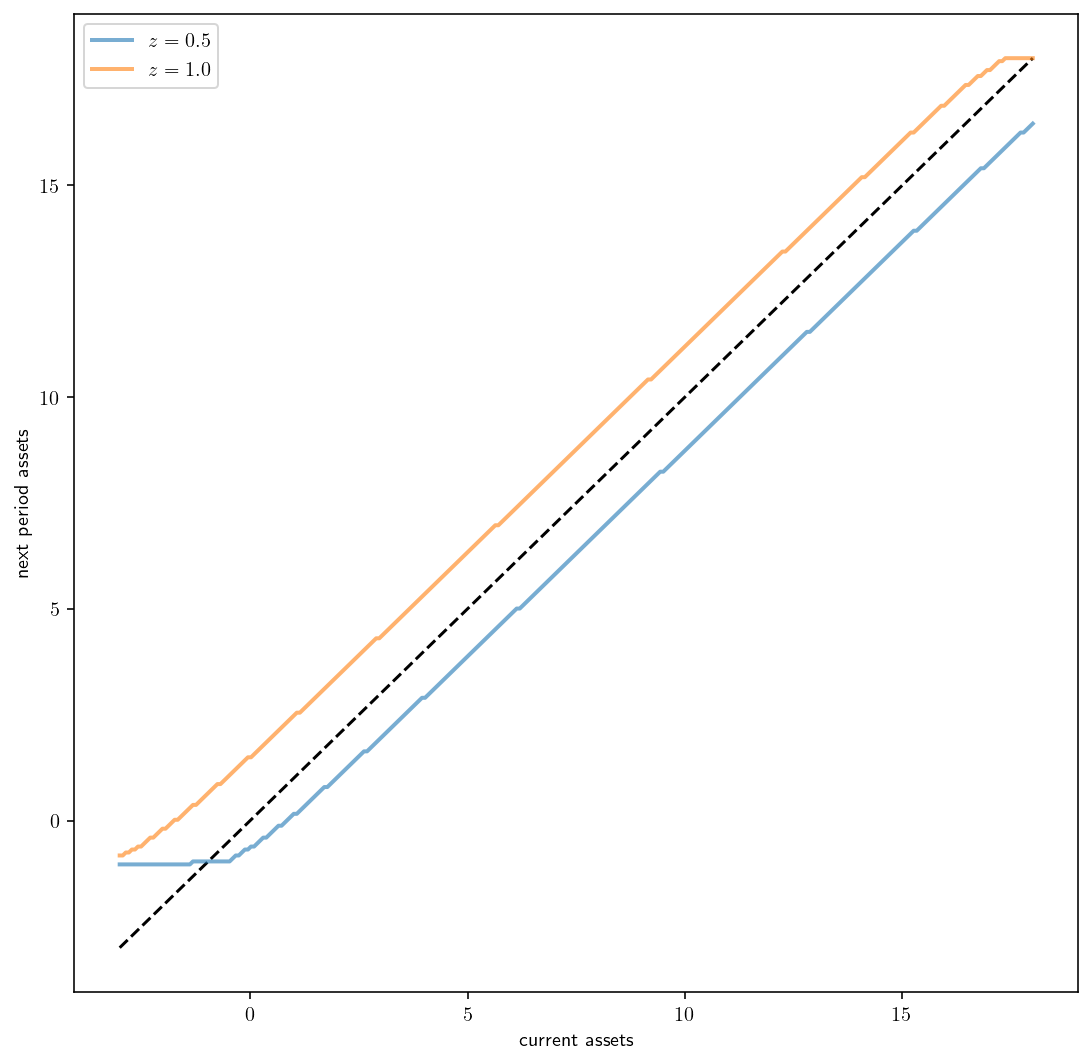

In [7]:
# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Solve using policy function iteration
results = am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = np.empty((z_size, a_size))
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
plt.show()

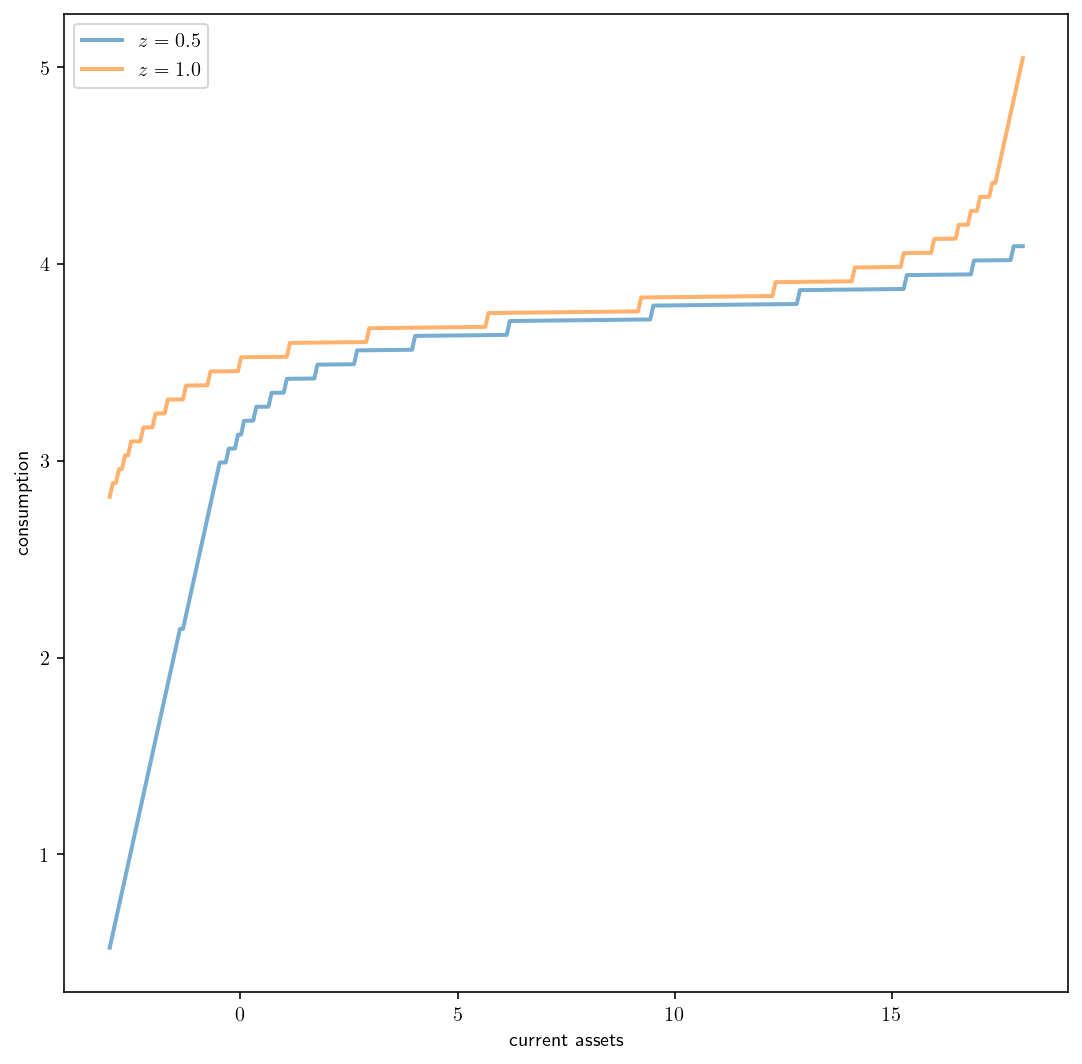

In [8]:
fig, ax = plt.subplots(figsize=(9, 9))
#ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, 5 * z_vals[i] + (1 + r) * a_vals - a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('consumption')
ax.legend(loc='upper left')
%config InlineBackend.figure_format = 'retina'
plt.show()

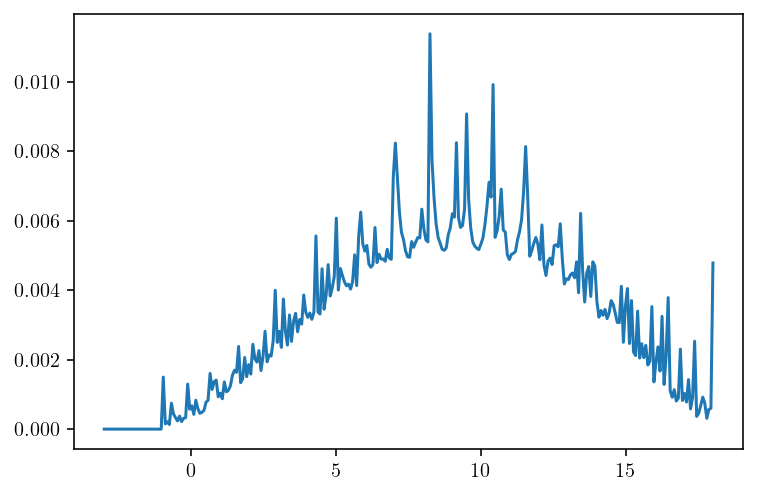

In [10]:
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
    return a_probs

stationary_probs = results.mc.stationary_distributions[0]
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

plt.plot(a_vals, asset_probs)
plt.show()

In [11]:
A = np.sum(asset_probs * am.a_vals)  
print('Total asset in the economy is', A)

if A>0:
    print('At this interest rate, too much saving!')
else:
    print('At this interest rate, too much borrowing!')

Total asset in the economy is 9.11877675010225
At this interest rate, too much saving!


#### Lets find the interest rate that clears the market

In [12]:
am = Household(r= 0.0001)
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
A = np.sum(asset_probs * am.a_vals)  
print('Total asset in the economy is', A)

if A>0:
    print('At this interest rate, too much saving!')
else:
    print('At this interest rate, too much borrowing!')
    


Total asset in the economy is 5.561992186851688
At this interest rate, too much saving!


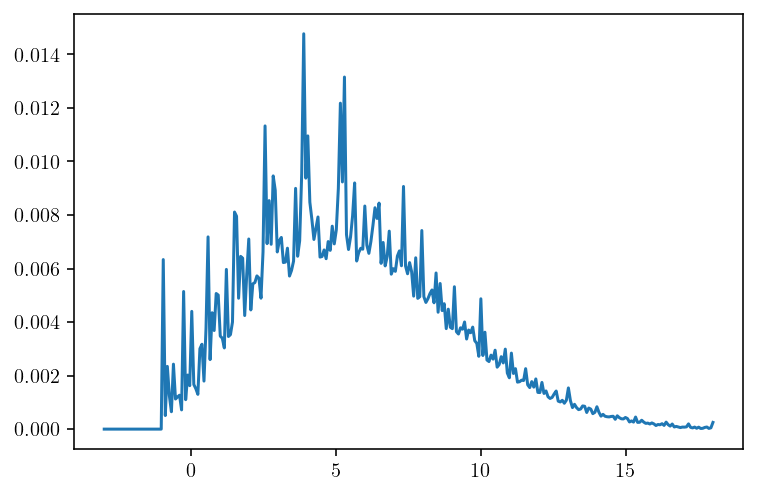

In [13]:
plt.plot(a_vals, asset_probs)
plt.show()

In [14]:
def total_A(r):
    am = Household(r= r)
    am_ddp = DiscreteDP(am.R, am.Q, am.β)
    results = am_ddp.solve(method='policy_iteration')
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    return np.sum(asset_probs * am.a_vals)  

In [15]:
import scipy.optimize as opt
r_sol = opt.bisect(total_A, -0.5, 0.005)
print('The interest rate that clears the bond market is', r_sol)

The interest rate that clears the bond market is -0.1079062608584536


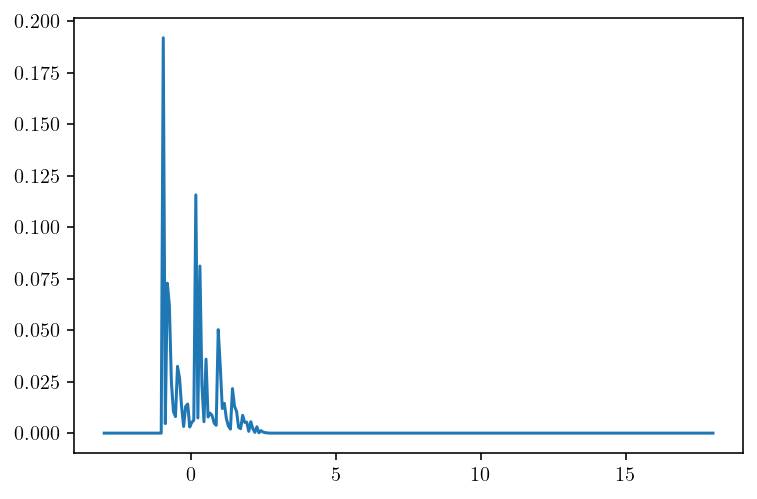

In [16]:
am = Household(r= r_sol)
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

plt.plot(a_vals, asset_probs)
plt.show()

### Solving with Euler Equation Iteration

Suppose we have a candidate policy function, $g_n(k,z)$

Our problem is:

$$E_{z′}[f(x,x′,x′′,z,z′) = 0 $$, all $x ∈ X$ and $z ∈ Z$

- Insert $g_n(k,z)$

$$ E_{z′}[f(x,x′,g_n(x′,z′),z,z′) = 0$$, all $x ∈ X$ and $z ∈ Z$

- Use a nonlinear equation solver to find $x′$ , and update to
$g_{n+1(x, z)}$.

- Iterate until

$$||E_{z′}[f(x,g_n(x,z),g_n(g_n(x,z),z′),z,z′)|| < ε$$

In [17]:
import numpy as np

gamma = 2.0
w=5        # wages
β=1.03**(-1/12)       # discount factor
r=0.00246       # interest rate
phi = -1.0
a_min= -3.0
Π = np.asarray([[0.4, 0.6], [0.6, 0.4]])  # Markov chain
z_vals=[0.5, 1]             
a_max=18
a_size=300
N = 300
mu = 0.5

In [18]:
from scipy.interpolate import interp1d

In [19]:
def time_g():
    #bgrid = np.linspace(a_min,np.log(18-phi+1),N)
    #a_vals = np.exp(bgrid)+phi-1;
    a_vals = np.linspace(a_min,a_max,N)
    ag1 = a_vals
    ab1 = a_vals
    ag = a_vals
    ab = a_vals
    metric = 1
    
    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = beta*(1+r)*( Π[0,1]*(a_vals*(1+r)+w-np.maximum(gg(a_vals),phi))**(-gamma)+Π[0,0]*(a_vals*(1+r)+mu*w-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = beta*(1+r)*( Π[1,1]*(a_vals*(1+r)+w-np.maximum(gg(a_vals),phi))**(-gamma)+Π[1,0]*(a_vals*(1+r)+mu*w-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w+a_vals)/(1+r)
        ab1 = (Eb**(-1/gamma)-mu*w+a_vals)/(1+r)
        
        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb

In [20]:
gg, gb = time_g()
a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)

In [21]:
#bgrid = np.linspace(-3,np.log(18-phi+1),N)
#a_vals = np.exp(bgrid)+phi-1;
a_vals = np.linspace(a_min,a_max,N)

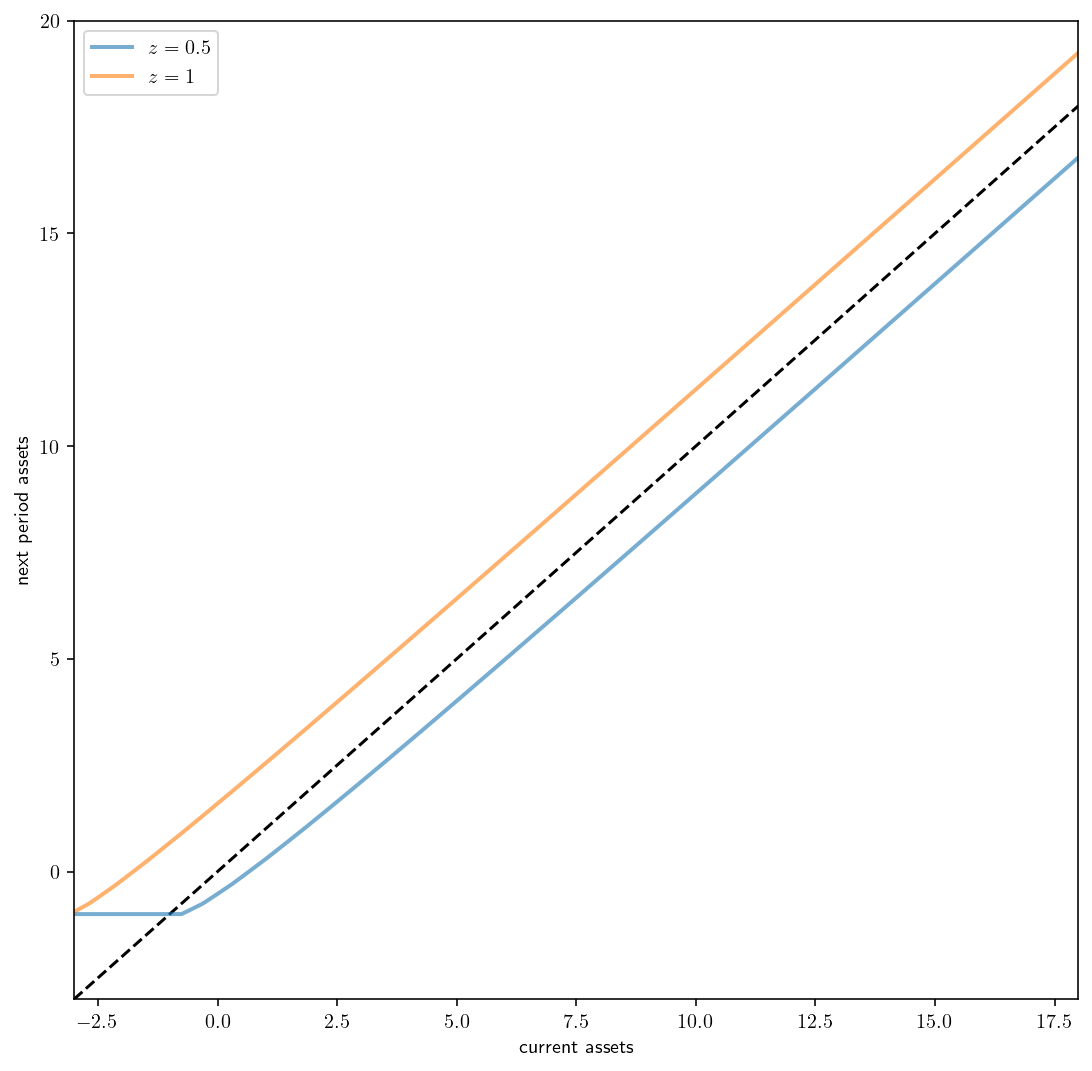

In [22]:
g = [a1b_star, a1g_star]
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, g[i], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
ax.set_xlim(-3,18)
ax.set_ylim(-3,20)
plt.show()

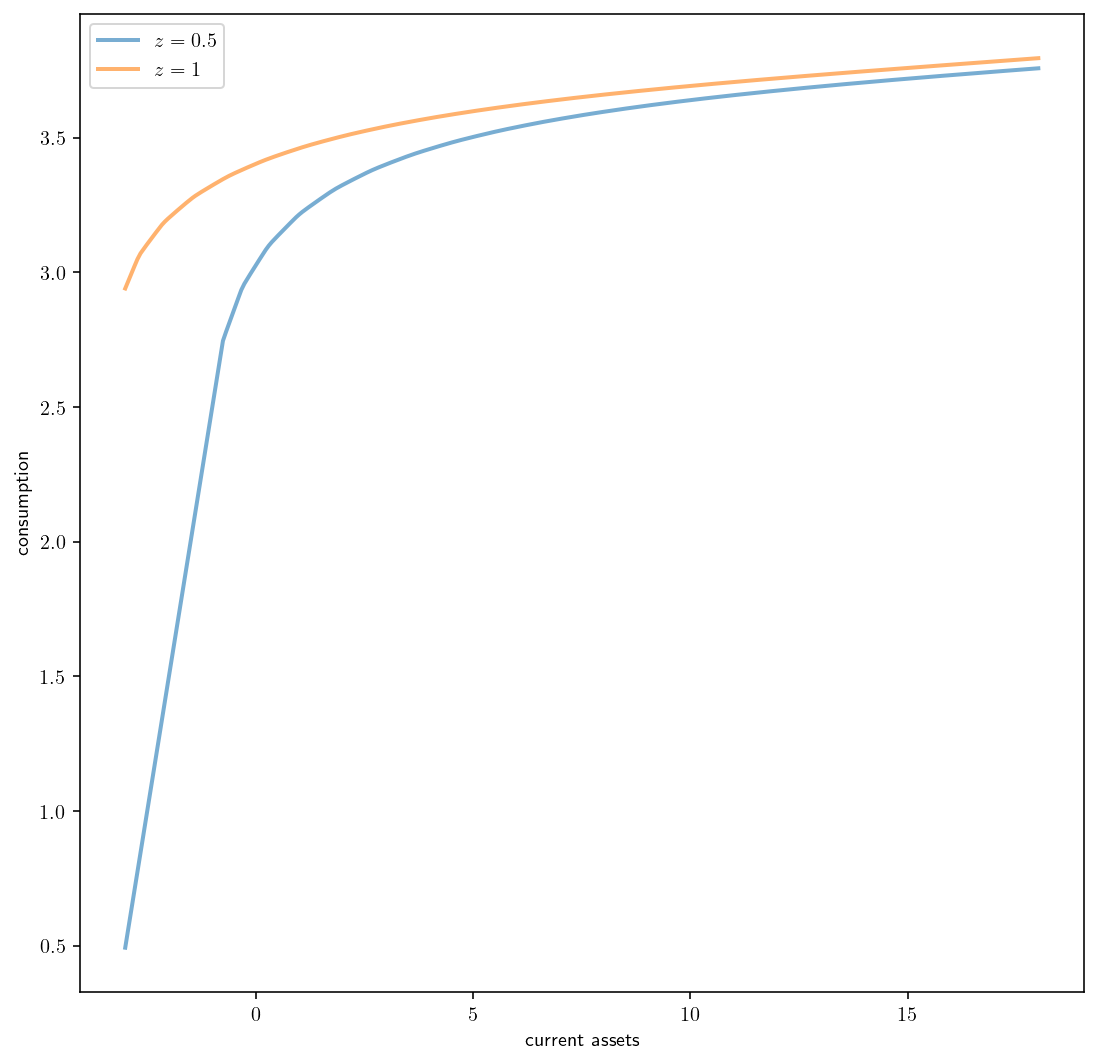

In [23]:
fig, ax = plt.subplots(figsize=(9, 9))
#ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, 5 * z_vals[i] + (1 + r) * a_vals - g[i], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('consumption')
ax.legend(loc='upper left')
plt.show()

In [24]:
F = interp1d(a_vals,a_vals, kind = 'next', fill_value = 18.0, bounds_error=False);
a1gd_star = F(np.maximum(gg(a_vals),phi));
a1bd_star = F(np.maximum(gb(a_vals),phi));

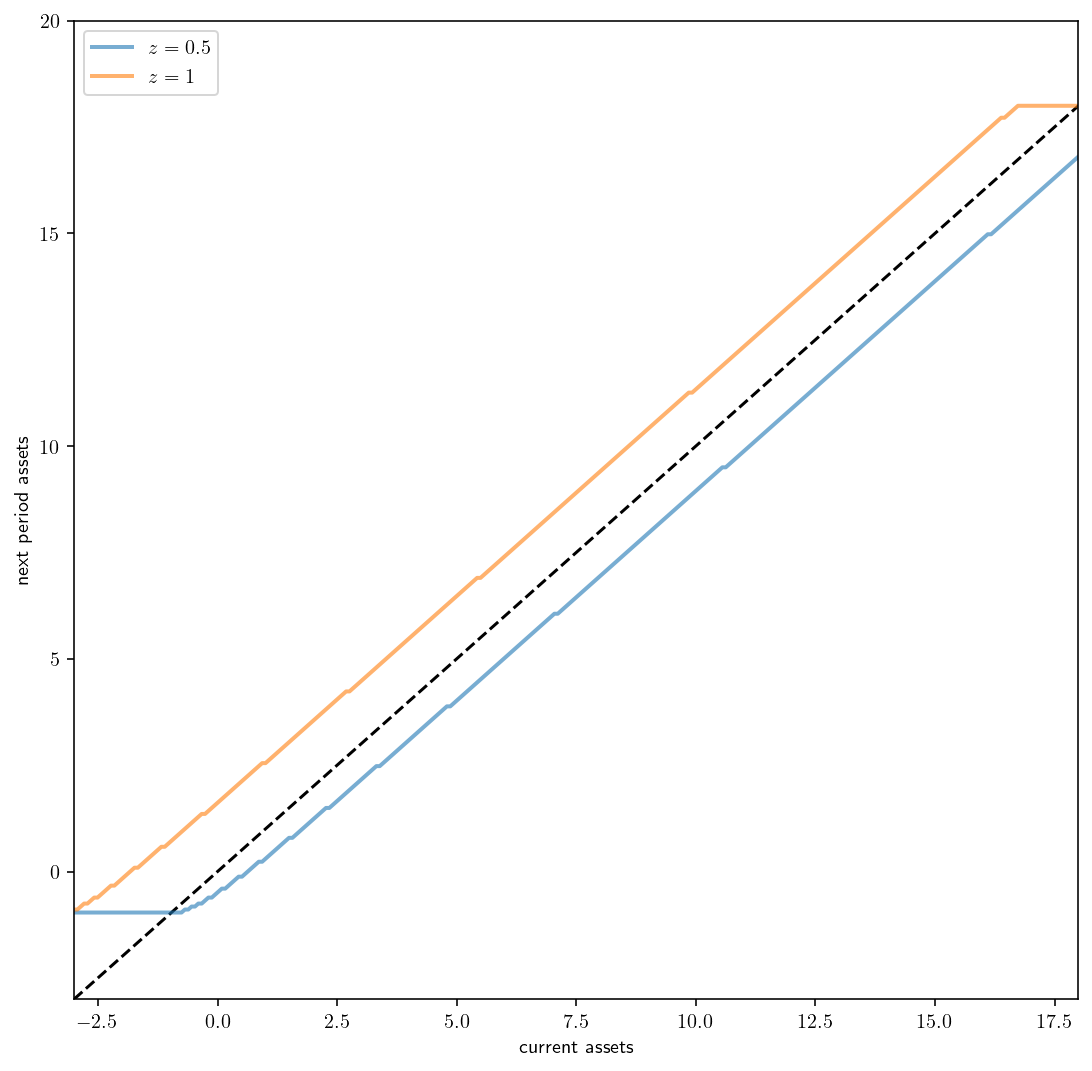

In [25]:
gd = [a1bd_star, a1gd_star]
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, gd[i], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
ax.set_xlim(-3,18)
ax.set_ylim(-3,20)
plt.show()

#### Getting the stationary distribution

In [26]:
Tg = np.zeros([N,N])
Tb = np.zeros([N,N])

for i in range(N):
    
    ixg = np.where(a_vals==a1gd_star[i])[0][0]
    Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
    if Tg[i,ixg] > 1:
        Tg[i,ixg] = 1.0
    Tg[i,ixg-1] = 1-Tg[i,ixg]
    
    ixb = np.where(a_vals==a1bd_star[i])[0][0]
    if ixb == 0:
        Tb[i,ixb] = 1
    else:
        Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
        Tb[i,ixb-1] = 1-Tb[i,ixb]

        
P = Π

M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)


from scipy.sparse import csr_matrix
M = csr_matrix(M)

M2 = csr_matrix.transpose(M)
import scipy.sparse.linalg as sla


D, V = sla.eigs(M2, k=1, sigma = 1.0)
V = np.real(V)/sum(np.real(V))
dist = V[0:N]+V[N:]

mean_a = np.dot(a_vals.T,dist);

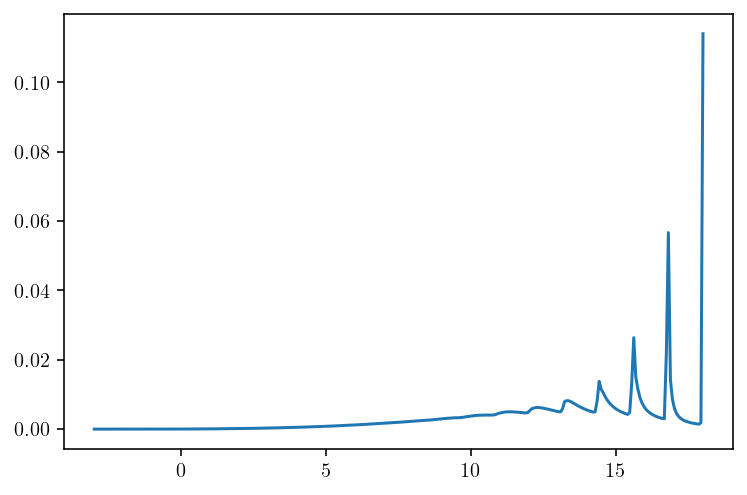

In [27]:
plt.plot(a_vals, dist)

#### Solving for equilibrium

In [28]:
import numpy as np

gamma = 2.0
w=5        # wages
β=1.03**(-1/12)       # discount factor
r=-0.1       # interest rate
phi = -1.0
a_min= -3.0
Π = np.asarray([[0.4, 0.6], [0.6, 0.4]])  # Markov chain
z_vals=[0.5, 1]             
a_max=18
a_size=10000
N = 10000
mu = 0.5

from scipy.interpolate import interp1d

def time_g():
    #bgrid = np.linspace(a_min,np.log(18-phi+1),N)
    #a_vals = np.exp(bgrid)+phi-1;
    a_vals = np.linspace(a_min,a_max,N)
    ag1 = a_vals
    ab1 = a_vals
    ag = a_vals
    ab = a_vals
    metric = 1
    
    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = beta*(1+r)*( Π[0,1]*(a_vals*(1+r)+w-np.maximum(gg(a_vals),phi))**(-gamma)+Π[0,0]*(a_vals*(1+r)+mu*w-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = beta*(1+r)*( Π[1,1]*(a_vals*(1+r)+w-np.maximum(gg(a_vals),phi))**(-gamma)+Π[1,0]*(a_vals*(1+r)+mu*w-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w+a_vals)/(1+r)
        ab1 = (Eb**(-1/gamma)-mu*w+a_vals)/(1+r)
        
        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb

gg, gb = time_g()
a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)

In [29]:
a_vals = np.linspace(a_min,a_max,N)

In [32]:
F = interp1d(a_vals,a_vals, kind = 'next', fill_value = 18.0, bounds_error=False);
a1gd_star = F(np.maximum(gg(a_vals),phi));
a1bd_star = F(np.maximum(gb(a_vals),phi));

Tg = np.zeros([N,N])
Tb = np.zeros([N,N])

for i in range(N):
    
    ixg = np.where(a_vals==a1gd_star[i])[0][0]
    Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
    if Tg[i,ixg] > 1:
        Tg[i,ixg] = 1.0
    Tg[i,ixg-1] = 1-Tg[i,ixg]
    
    ixb = np.where(a_vals==a1bd_star[i])[0][0]
    if ixb == 0:
        Tb[i,ixb] = 1
    else:
        Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
        Tb[i,ixb-1] = 1-Tb[i,ixb]

        
P = Π

M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)


from scipy.sparse import csr_matrix
M = csr_matrix(M)

M2 = csr_matrix.transpose(M)
import scipy.sparse.linalg as sla


D, V = sla.eigs(M2, k=1, sigma = 1.0)
V = np.real(V)/sum(np.real(V))
dist = V[0:N]+V[N:]

mean_a = np.dot(a_vals.T,dist);
print(mean_a)
plt.plot(a_vals, dist)
plt.show()

IndexError: index 300 is out of bounds for axis 0 with size 300